##  Description on ventilator pressure.

What do doctors do when a patient has trouble breathing? They use a ventilator to pump oxygen into a sedated patient's lungs via a tube in the windpipe.

Current simulators are trained as an ensemble, where each model simulates a single lung setting. However, lungs and their attributes form a continuous space, so a parametric approach must be explored that would consider the differences in patient lungs.

If successful, you'll help overcome the cost barrier of developing new methods for controlling mechanical ventilators. As a result, ventilator treatments may become more widely available to help patients breathe.

## Problem Statement.

The competition will be scored as the mean absolute error between the predicted and actual pressures during the inspiratory phase of each breath. The expiratory phase is not scored. The score is given by:

where 
 is the vector of predicted pressure and 
 is the vector of actual pressures across all breaths in the test set.

Submission File
For each id in the test set, you must predict a value for the pressure variable. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ventilator-pressure-prediction/sample_submission.csv
/kaggle/input/ventilator-pressure-prediction/train.csv
/kaggle/input/ventilator-pressure-prediction/test.csv


#  Import Libraries

In [2]:
import pandas as pd
import numpy as np   
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import median_absolute_error

# Reading test_data and train_data

In [3]:
train_data=pd.read_csv('/kaggle/input/ventilator-pressure-prediction/train.csv')
test_data=pd.read_csv('/kaggle/input/ventilator-pressure-prediction/test.csv')

# viewing the top 5 rows.

In [4]:
train_data.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


#  Head of test_data

In [5]:
test_data.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


# Detailed Data 

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


#  Data Summary

In [7]:
train_data.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


# correlation

,id,breath_id,R,C,time_step,u_in,u_out,pressure
id,1.000000,0.999999,0.001853,0.007222,-0.000199,-0.002380,-0.000089,-0.002402
breath_id,0.999999,1.000000,0.001860,0.007222,-0.000213,-0.002378,-0.000100,-0.002394
R,0.001853,0.001860,1.000000,-0.096070,-0.014535,-0.148120,-0.007594,0.015976
C,0.007222,0.007222,-0.096070,1.000000,0.004936,0.151002,0.003720,-0.036727
time_step,-0.000199,-0.000213,-0.014535,0.004936,1.000000,-0.352276,0.839191,-0.524829
u_in,-0.002380,-0.002378,-0.148120,0.151002,-0.352276,1.000000,-0.416985,0.308136
u_out,-0.000089,-0.000100,-0.007594,0.003720,0.839191,-0.416985,1.000000,-0.614910
pressure,-0.002402,-0.002394,0.015976,-0.036727,-0.524829,0.308136,-0.614910,1.000000


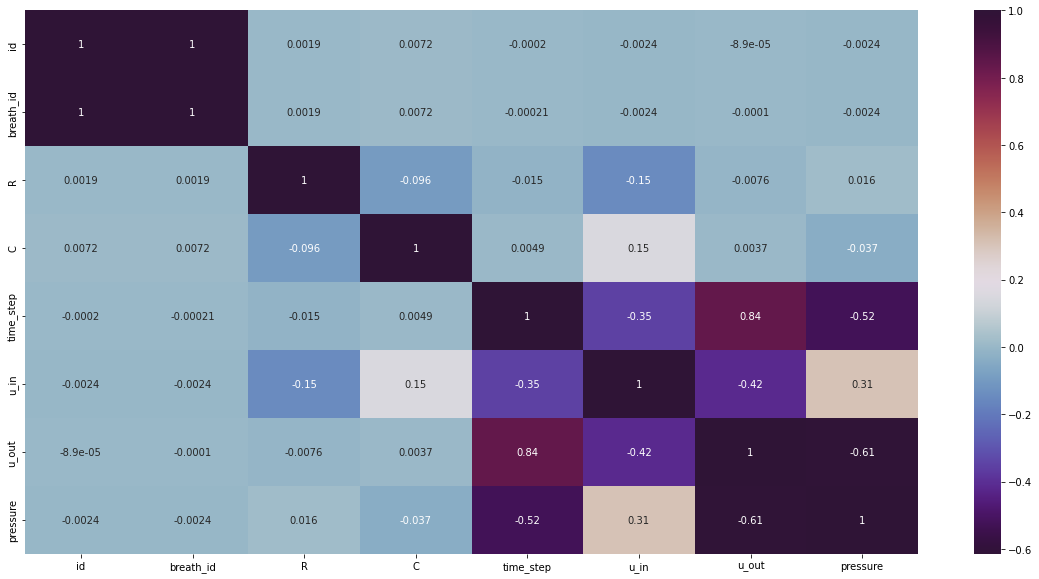

In [8]:
Z=train_data.corr()
plt.figure(figsize=(20,10))
sns.heatmap(Z,annot=True,cmap='twilight_shifted')
Z

# Inquiring null data.

In [9]:
data_null=pd.DataFrame(train_data.isnull().sum(),columns=['Number of null'])
data_null['percentage']=(train_data.isnull().sum())/len(train_data)*100
data_null

,Number of null,percentage
id,0,0.0
breath_id,0,0.0
R,0,0.0
C,0,0.0
time_step,0,0.0
u_in,0,0.0
u_out,0,0.0
pressure,0,0.0


# Checking for duplicate data

In [10]:
train_data[train_data.duplicated()]

,id,breath_id,R,C,time_step,u_in,u_out,pressure


# Data visualization 

Showing  distribution of some columns in the data

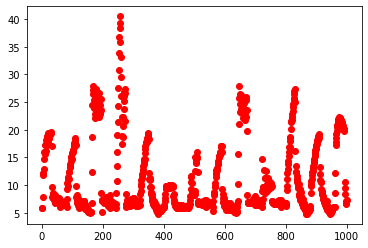

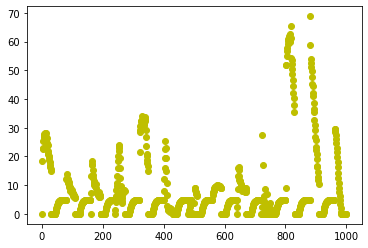

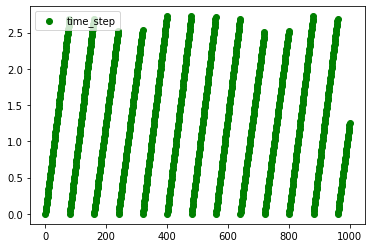

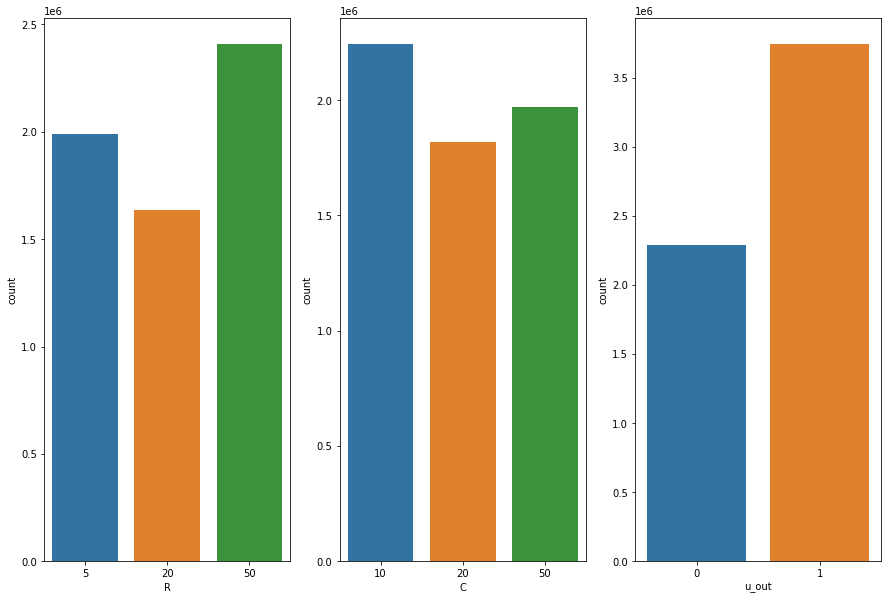

In [11]:
x=list(range(1,train_data.shape[0]+1))
plt.scatter(x[:1000],train_data['pressure'][:1000],c='r',label='pressure')
plt.figure()
plt.scatter(x[:1000],train_data['u_in'][:1000],c='y',label='u_in')
plt.figure()
plt.scatter(x[:1000],train_data['time_step'][:1000],c='g',label='time_step')
plt.legend()
column=['R','C','u_out']
i=1
plt.figure(figsize=(15,10))
for col in column:
    plt.subplot(1,3,i)
    sns.countplot(x=col,data=train_data)
    i+=1

# Dropping columns

In [12]:
id=test_data['id']
train_data.drop('id',axis=1,inplace=True)
train_data.drop('breath_id',axis=1,inplace=True)
test_data.drop('id',axis=1,inplace=True)
test_data.drop('breath_id',axis=1,inplace=True)

# Splitting the input X and output y

In [13]:
X=train_data.iloc[:,:-1]
y=train_data.iloc[:,-1]
key=X.keys()

# Input (X)

In [14]:
X

,R,C,time_step,u_in,u_out
0,20,50,0.000000,0.083334,0
1,20,50,0.033652,18.383041,0
2,20,50,0.067514,22.509278,0
3,20,50,0.101542,22.808822,0
4,20,50,0.135756,25.355850,0
...,...,...,...,...,...
6035995,50,10,2.504603,1.489714,1
6035996,50,10,2.537961,1.488497,1
6035997,50,10,2.571408,1.558978,1
6035998,50,10,2.604744,1.272663,1


# Target (y)

In [15]:
y

0           5.837492
1           5.907794
2           7.876254
3          11.742872
4          12.234987
             ...    
6035995     3.869032
6035996     3.869032
6035997     3.798729
6035998     4.079938
6035999     3.869032
Name: pressure, Length: 6036000, dtype: float64

# Scalling- MinMaxScaler 

In [16]:
scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
X = scaler.fit_transform(X)
test_data=scaler.fit_transform(test_data)
pd.DataFrame(X,columns=key)

,R,C,time_step,u_in,u_out
0,0.333333,1.0,0.000000,0.000833,0.0
1,0.333333,1.0,0.011457,0.183830,0.0
2,0.333333,1.0,0.022986,0.225093,0.0
3,0.333333,1.0,0.034571,0.228088,0.0
4,0.333333,1.0,0.046219,0.253559,0.0
...,...,...,...,...,...
6035995,1.000000,0.0,0.852707,0.014897,1.0
6035996,1.000000,0.0,0.864064,0.014885,1.0
6035997,1.000000,0.0,0.875451,0.015590,1.0
6035998,1.000000,0.0,0.886801,0.012727,1.0


# Splitting data into train and test.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=44, shuffle =True)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape) 

X_train shape is  (4044120, 5)
X_test shape is  (1991880, 5)
y_train shape is  (4044120,)
y_test shape is  (1991880,)


# Performing Random Forest Regressor Model 

In [18]:
RandomForestRegressorModel = RandomForestRegressor(n_estimators=100,max_depth=25, random_state=33)
RandomForestRegressorModel.fit(X_train, y_train)
#Calculating Details
print('Random Forest Regressor Train Score is : ' , RandomForestRegressorModel.score(X_train, y_train))
print('Random Forest Regressor Test Score is : ' , RandomForestRegressorModel.score(X_test, y_test))
print('Random Forest Regressor No. of features are : ' , RandomForestRegressorModel.n_features_)
#Calculating Prediction
y_pred = RandomForestRegressorModel.predict(X_test)
print('Predicted Value for Random Forest Regressor is : ' , y_pred[:10])

Random Forest Regressor Train Score is :  0.8854829533564718
Random Forest Regressor Test Score is :  0.7803964838854669
Random Forest Regressor No. of features are :  5


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


Predicted Value for Random Forest Regressor is :  [11.07800699 19.52671074  5.45233595  6.02983589  6.07573396  7.1016047
 19.5162863   6.44321104 17.49098513  6.04287624]


# Evaluating the metrics.

To analysis the performance of the model fitted.

In [19]:
#Calculating Mean Absolute Error
MAEValue = mean_absolute_error(y_test, y_pred, multioutput='uniform_average') # it can be raw_values
print('Mean Absolute Error Value is : ', MAEValue)

#----------------------------------------------------
#Calculating Mean Squared Error
MSEValue = mean_squared_error(y_test, y_pred, multioutput='uniform_average') # it can be raw_values
print('Mean Squared Error Value is : ', MSEValue)

#----------------------------------------------------
#Calculating Median Absolute Error
MdSEValue = median_absolute_error(y_test, y_pred)
print('Median Absolute Error Value is : ', MdSEValue )

Mean Absolute Error Value is :  1.8713692762216023
Mean Squared Error Value is :  14.452494233412335
Median Absolute Error Value is :  0.4821289415154695


# Plotting actual  and pred value.

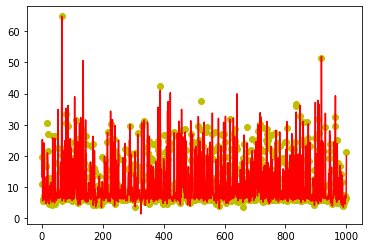

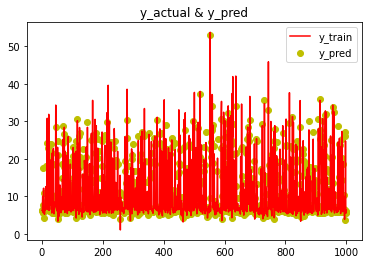

In [20]:
x=list(range(1,train_data.shape[0]+1))
plt.plot(x[:1000],y_test[:1000],c='r',label='y_test')
plt.scatter(x[:1000],y_pred[:1000],c='y',label='y_pred')
plt.figure()
plt.plot(x[:1000],y_train[:1000],c='r',label='y_train')
plt.scatter(x[:1000],RandomForestRegressorModel.predict(X_train)[:1000],c='y',label='y_pred')
plt.title('y_actual & y_pred')
plt.legend()

# Predicting test_data

In [21]:
y_test=RandomForestRegressorModel.predict(test_data)
submission=pd.DataFrame(index=id)
submission['pressure']=y_test
submission.to_csv('/kaggle/working/submission.csv')
submission

,pressure
id,
1,6.314524
2,5.983199
3,6.818115
4,7.661462
5,9.019264
...,...
4023996,6.032265
4023997,6.101888
4023998,6.100420
